In [49]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# choose whether to work on a remote machine
location = "remote"
# location = "local"

if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

# Data storage setup

In [51]:
# import necessary packages

# from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs

import rasterio
from rasterio.plot import show
import rioxarray as rio


from coralshift.processing import spatial_data
from coralshift.utils import file_ops, directories, utils
from coralshift.dataloading import data_structure, climate_data, bathymetry, reef_extent
from coralshift.plotting import spatial_plots


In [60]:
np.mean(spatial_data.degrees_to_distances(1/3))

36157.97860466514

In [ ]:
# ds_man = data_structure.MyDatasets()
# ds_man.set_location(location)

## Specify your area of interest

The availability of high-resolution (30m) bathymetric data means that areas of interest are currently confided to 4 areas on the Great Barrier Reef (GBR). The following code generates a geoJSON file specifying which area (A-D) you'd like to investigate:

| Reef Area Name                	| Latitudes 	| Longitudes 	|
|-------------------------------	|-----------	|------------	|
| Great Barrier Reef A 2020 30m 	| 10-17°S   	| 142-147°E  	|
| Great Barrier Reef B 2020 30m 	| 16-23°S   	| 144-149°E  	|
| Great Barrier Reef C 2020 30m 	| 18-24°S   	| 148-154°E  	|
| Great Barrier Reef D 2020 30m 	| 23-29°S   	| 150-156°E  	|


Download your required area from here: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/115066

Due to the computational load required to run ML models on such a high resolution data, bathymetric data is currently upsampled to 4km grid cells and areas are limited to a quarter of the GBR's total area.

In [4]:
# choose resolution (should be above 1000m for processing in decent time)
target_resolution_m, target_resolution_d = spatial_data.choose_resolution(
    resolution=1000, unit="m")

# convert distance to degrees:
# _,_,av_degrees = spatial_data.distance_to_degrees(target_resolution)
print(f"Data will be downsampled to {target_resolution_d:.05f} degrees (~{target_resolution_m}m).")

Data will be downsampled to 0.00923 degrees (~1000m).


## Bathymetry

In [5]:
# select your area. Region "A" is used in the report
area_name = "A"
reef_areas = bathymetry.ReefAreas()

# TODO: plot with different areas to choose from

_, xa_bath = bathymetry.generate_bathymetry_xa_da(area_name)
_, xa_bath_upsampled = spatial_data.upsample_and_save_xa_a(
    directories.get_bathymetry_datasets_dir(), xa_d= xa_bath, name="bathymetry_A", target_resolution_d=target_resolution_d)

Great_Barrier_Reef_A_2020_30m_MSL_cog already exists in /lustre_scratch/orlando-code/datasets/bathymetry
bathymetry_A_0-00030d already exists in /lustre_scratch/orlando-code/datasets/bathymetry
bathymetry_A_0-0092276d already exists in /lustre_scratch/orlando-code/datasets/bathymetry


In [16]:
xa_bath.rio.crs

In [24]:
def generate_bathymetry_xa_da(area_name: str):
    """
    Generate bathymetry data for a specified area.

    Parameters
    ----------
        area_name (str): The name of the area.

    Returns
    -------
        tuple[str, xa.DataArray]: A tuple containing the filepath and the processed xarray of the generated bathymetry
        data.
    """
    # download .tif if not downloaded aready
    reef_areas = bathymetry.ensure_bathymetry_downloaded(area_name)
    # cast tif to processed xarray with correct crs
    xa_bath = spatial_data.tif_to_xarray(
        directories.get_bathymetry_datasets_dir() / reef_areas.get_filename(area_name),
        reef_areas.get_xarray_name(area_name),
    )

    resolution = np.mean(spatial_data.calculate_spatial_resolution(xa_bath))
    dir = directories.get_bathymetry_datasets_dir()
    bath_name = f"{reef_areas.get_xarray_name(area_name)}_{resolution:.05f}d"
    filepath, xa_da = save_nc(
        dir, bath_name, xa_bath, return_array=True
    )

    return filepath, xa_da


def save_nc(
    save_dir: Path | str,
    filename: str,
    xa_d: xa.DataArray | xa.Dataset,
    return_array: bool = False,
) -> xa.DataArray | xa.Dataset:
    """
    Save the given xarray DataArray or Dataset to a NetCDF file iff no file with the same
    name already exists in the directory.
    # TODO: issues when suffix provided
    Parameters
    ----------
        save_dir (Path or str): The directory path to save the NetCDF file.
        filename (str): The name of the NetCDF file.
        xa_d (xarray.DataArray or xarray.Dataset): The xarray DataArray or Dataset to be saved.

    Returns
    -------
        xarray.DataArray or xarray.Dataset: The input xarray object.
    """
    filename = file_ops.remove_suffix(utils.replace_dot_with_dash(filename))
    save_path = (Path(save_dir) / filename).with_suffix(".nc")
    if not save_path.is_file():
        print(f"Writing {filename} to file at {save_path}")
        test = process_xa_d(xa_d).to_netcdf(save_path)
    else:
        print(f"{filename} already exists in {save_dir}")

    if return_array:
        if isinstance(xa_d, xa.DataArray):
            return save_path, xa.open_dataarray(save_path)
        elif isinstance(xa_d, xa.Dataset):
            return save_path, xa.open_dataset(save_path)
    else:
        return save_path


def process_xa_d(
    xa_d: xa.Dataset | xa.DataArray,
    rename_mapping: dict = {
        "lat": "latitude",
        "lon": "longitude",
        "x": "longitude",
        "y": "latitude",
    },
    squeeze_coords: str | list[str] = None,
    chunk_dict: dict = {"latitude": 100, "longitude": 100, "time": 100},
    crs: str = "EPSG:4326",
):
    """
    Process the input xarray Dataset or DataArray by standardizing coordinate names, squeezing dimensions,
    chunking along specified dimensions, and sorting coordinates.

    Parameters
    ----------
        xa_d (xa.Dataset or xa.DataArray): The xarray Dataset or DataArray to be processed.
        rename_mapping (dict, optional): A dictionary specifying the mapping for coordinate renaming.
            The keys are the existing coordinate names, and the values are the desired names.
            Defaults to a mapping that standardizes common coordinate names.
        squeeze_coords (str or list of str, optional): The coordinates to squeeze by removing size-1 dimensions.
                                                      Defaults to ['band'].
        chunk_dict (dict, optional): A dictionary specifying the chunk size for each dimension.
                                     The keys are the dimension names, and the values are the desired chunk sizes.
                                     Defaults to {'latitude': 100, 'longitude': 100, 'time': 100}.

    Returns
    -------
        xa.Dataset or xa.DataArray: The processed xarray Dataset or DataArray.

    """

    # standardise coordinate names
    # temp_xa_d = xa_d.rename(
    #     {"lat": "latitude", "lon": "longitude", "x": "longitude", "y": "latitude"}
    # )

    temp_xa_d = xa_d.copy()

    for coord, new_coord in rename_mapping.items():
        if new_coord not in temp_xa_d.coords and coord in temp_xa_d.coords:
            temp_xa_d = temp_xa_d.rename({coord: new_coord})
    # temp_xa_d = xa_d.rename(
    #     {coord: rename_mapping.get(coord, coord) for coord in xa_d.coords}
    # )
    if "band" in temp_xa_d.dims:
        temp_xa_d = temp_xa_d.squeeze("band")
    if squeeze_coords:
        temp_xa_d = temp_xa_d.squeeze(squeeze_coords)

    # add crs
    temp_xa_d.rio.write_crs(crs, inplace=True)
    chunked_xa_d = spatial_data.chunk_as_necessary(temp_xa_d, chunk_dict)
    # sort coords by ascending values
    return chunked_xa_d.sortby(list(temp_xa_d.dims))


_, xa_bath = generate_bathymetry_xa_da("A")


Great_Barrier_Reef_A_2020_30m_MSL_cog already exists in /lustre_scratch/orlando-code/datasets/bathymetry
Writing bathymetry_A_0-00030d to file at /lustre_scratch/orlando-code/datasets/bathymetry/bathymetry_A_0-00030d.nc


ValueError: Given file dataset contains more than one data variable. Please read with xarray.open_dataset and then select the variable you want.

In [6]:
# compute dasked arrays for plotting
xa_bath_upsampled = xa_bath_upsampled.compute()

In [26]:
xa_bath.rio.crs

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

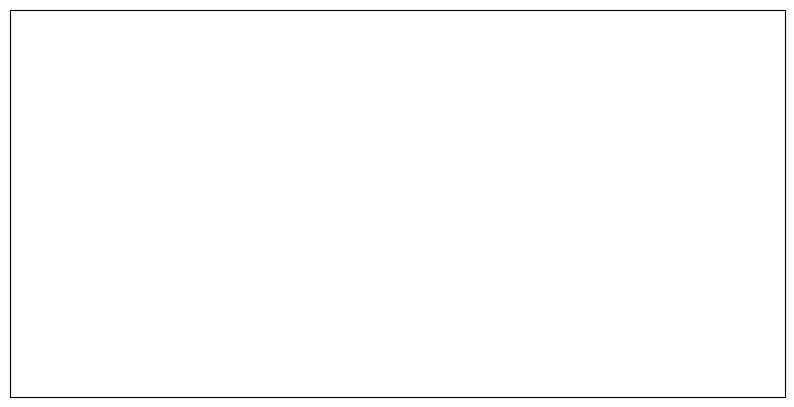

In [7]:
# N.B. native resolution not plotted since so high (takes ~10 minutes)
spatial_plots.plot_spatial(xa_bath_upsampled, val_lims=(-50,0), name="depth", 
    title=f"Bathymetry at {target_resolution_m}m resolution")

## Calculate slopes

In [ ]:
# calculate absolute gradients from bathymetry and save to file
grads, grads_path = bathymetry.generate_gradient_magnitude_nc(xa_bath_up_vals, sigma=1)

In [ ]:
# compute dasked array for plotting
grads = grads.compute()

In [ ]:
### Display different resolutions
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16,9), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = spatial_plots.plot_spatial(xa_bath_upsampled, 
    fax= (fig,ax_left), val_lims=(-50,0), name="depth", title=f"Bathymetry at {target_resolution_m}m resolution")
ax2 = spatial_plots.plot_spatial(grads, 
    fax=(fig, ax_right), val_lims=(0,10), name="gradient magnitude", 
    title=f"Absolute seafloor gradients at {target_resolution_m}m resolution")

## Coral ground truth: Allen Coral Atlas


There is currently no API for accessing data directly from your local machine. Please follow the instructions* below:
1. Make an account on the [Allen Coral Atlas](https://allencoralatlas.org/atlas/#6.00/-13.5257/144.5000) webpage
2. Generate a geojson file using the code cell below (generated in the `reef_baseline` directory)

*Instructions correct as of 30.06.23

In [ ]:
# generate geojson file in reef_baseline directory for download from the Allen Coral Atlas
geojson_path = reef_extent.generate_area_geojson(
    area_class = reef_areas, area_name=area_name, save_dir=directories.get_reef_baseline_dir())

3. Upload the geojson file via:

    \> My Areas > Upload a GeoJSON or KML file
4. Wait for the area to be processed, and select "Benthic Map (OGC GeoPackage (.gpkg))". Sign the terms and conditions 
and select "Prepare Download". After ~two minutes a sequence of emails will arrive notifying you that your download is ready.
5. Download the file and unzip it using a unzipping utility. Then, add the `benthic.gpkg` file to the `reef_baseline` directory.
6. Continue with the subsequent code cells.

----

You have now downloaded:

**`benthic.gpkg`**

This is a dataframe of Shapely objects ("geometry" polygons) defining the boundaries of different benthic classes:

| Class           	| Number of polygons 	|
|-----------------	|--------------------	|
| Coral/Algae     	| 877787             	|
| Rock            	| 766391             	|
| Rubble          	| 568041             	|
| Sand            	| 518805             	|
| Microalgal Mats 	| 27569              	|

In [ ]:
# read .gpkg file and save to .pkl format for faster reading later
benthic_df = file_ops.check_pkl_else_read_gpkg(directories.get_reef_baseline_dir(), filename = "benthic.pkl")
benthic_df.head()

### Rasterize polygons

Rasterized arrays are necessary to process the geospatial data e.g. to align different gridcells. Doing this locally through rasterio requires such significant compute that cloud computing is the only reasonable option. A JavaScript file (`rasterization.js`) for use in Google Earth Engine (GEE) is provided in the `coralshift` repo. Visit [this page](https://developers.google.com/earth-engine/guides/getstarted) for information regarding setting up a GEE account and getting started.

GEE requires shapefile (.shp) format to ingest data. This is generated in the following cell:


In [ ]:
# process df to gpd.GeoDataFrame. 
# We are interested only in the "Coral/Algae" class, so gdf is limited to these rows by default
gdf_coral = reef_extent.process_benthic_pd(benthic_df)
# save as shapely file (if not already present) for rasterisation in GEE
reef_extent.generate_coral_shp(gdf_coral)

1. Ingest the shapefile (and all accompanying files: .cpg, .dbf, .prj, .shx) as a GEE asset.
2. Import the subsequent `Table` into the script.
3. Update the `resolution` variable as desired (usually that matching the target resolution specified above).
3. Run the script, and submit the `coral_raster_Xm` task. Sit back and wait! After ~1 hour (depending on the chosen resolution) the rasters will be available to download from your Google Drive as GeoTIFFS: after this, add them to the `reef_baseline` directory and carry on with the following cells.

In [48]:
# process all tifs in folder, casting to nc files for future use
reef_extent.process_reef_extent_tifs()


coral_raster_1000m already exists in /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files
coral_region_A_30m_mean already exists in /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files
Writing coral_region_A_1000m_mean to file at /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files/coral_region_A_1000m_mean.nc
coral_region_A_30m already exists in /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files


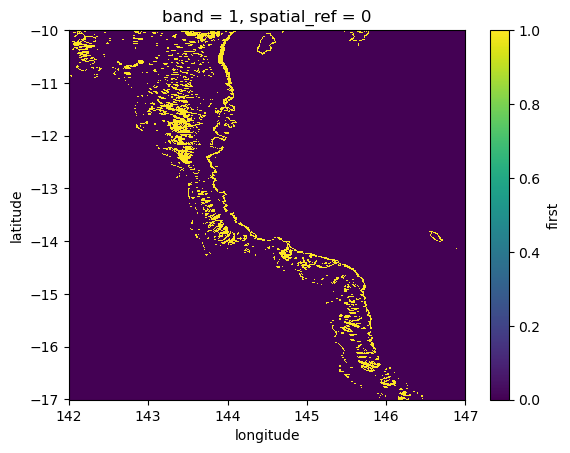

In [40]:
# TODO: automated visualisation

gt_tif_dict['coral_raster_1000m'].plot()

## Global Ocean Physics Reanalysis

The dataset metadata can be accessed [here](https://doi.org/10.48670/moi-00021).

### Download data

You're required to set up an account with the [Copernicus Marine Service](https://marine.copernicus.eu/). 


**Warning:**  this is a large amount of data for which the only way to gather it is to query the copernicus API via motu. Requests are queued, and request sizes are floated to the top of the queue. The following functions take advantage of this by splitting a single request up by date adn variable before amalgamating the files, but this can still take a **very long time**, and vary significantly depending on overall website traffic. For those who aren't interested in the entire database, it's highly recommended that you use the toy dataset provided as a `.npy` file in the GitHub repository.


In [ ]:
# download monthly data. Can be adjusted to specify subset of variables, dates, and depths to download.
# Values generated here are those reported in the accompanying paper.
xa_cmems_monthly, cmems_monthly_path = climate_data.download_reanalysis(download_dir=directories.get_monthly_cmems_dir(), 
    final_filename = "cmems_gopr_monthly",
    lat_lims = reef_areas.get_lat_lon_limits(area_name)[0], lon_lims = reef_areas.get_lat_lon_limits(area_name)[1], 
    product_id = "cmems_mod_glo_phy_my_0.083_P1M-m")   


In [ ]:
# download daily data
xa_cmems_daily, cmems_daily_path = climate_data.download_reanalysis(download_dir=directories.get_daily_cmems_dir(), 
    final_filename = "cmems_gopr_daily.nc",
    lat_lims = reef_areas.get_lat_lon_limits(area_name)[0], lon_lims = reef_areas.get_lat_lon_limits(area_name)[1], 
    product_id = "cmems_mod_glo_phy_my_0.083_P1D-m")   

### Spatially pad the data

TODO: add visual explanation

In [ ]:
def spatially_buffer_timeseries(
    xa_ds: xa.Dataset,
    buffer_size: int = 3,
    exclude_vars: list[str] = ["spatial_ref", "coral_algae_1-12_degree"],
) -> xa.Dataset:
    """Applies a spatial buffer to each data variable in the xarray dataset.

    Parameters
        xa_ds (xarray.Dataset): Input xarray dataset.
        buffer_size (int): Buffer size in grid cells.
        exclude_vars (list[str]): List of variable names to exclude from buffering.

    Returns:
        xarray.Dataset: Xarray dataset with buffered data variables.
    """
    filtered_vars = [var for var in xa_ds.data_vars if var not in exclude_vars]

    buffered_ds = xa.Dataset()
    for data_var in tqdm(
        filtered_vars, desc=f"Buffering variables by {buffer_size} pixel(s)"
    ):
        buffered = xa.apply_ufunc(
            spatial_data.buffer_nans,
            xa_ds[data_var],
            input_core_dims=[[]],
            output_core_dims=[[]],
            kwargs={"size": buffer_size},
            dask="parallelized",
        )
        buffered_ds[data_var] = buffered

    return buffered_ds


def spatially_buffer_nc_file(nc_path: Path | str, buffer_size: int = 3):
    # TODO: specify distance buffer
    nc_path = Path(nc_path)
    buffered_name = nc_path.stem + f"_buffered_{buffer_size}_pixel"
    buffered_path = (nc_path.parent / buffered_name).with_suffix(".nc")

    # if buffered file doesn't already exist
    if not buffered_path.is_file():
        nc_file = xa.open_dataset(nc_path)
        buffered_ds = spatially_buffer_timeseries(
            nc_file, buffer_size=buffer_size
        )
        buffered_ds.to_netcdf(buffered_path)
    else:
        buffered_ds = xa.open_dataset(buffered_path)
        print(
            f"Area buffered by {buffer_size} pixel(s) already exists at {buffered_path}."
        )

    return buffered_ds, buffered_path

In [ ]:
# xa_cmems_monthly_buffered, _ = spatial_data.spatially_buffer_nc_file(cmems_monthly_path, buffer_size=5)
xa_cmems_daily_buffered, _ = spatially_buffer_nc_file(cmems_daily_path, buffer_size=5)
# TODO: this taking forever (seemingly getting stuck after second variable)

In [ ]:
spatial_plots.plot_DEM(xa.open_dataset(directories.get_monthly_cmems_dir() / "cmems_gopr_monthly_buffered_5_pixel")["mlotst"].isel(time=0), "")
# spatial_plots.plot_DEM(buffered["mlotst"].isel(time=0), "")

## Load ERA5 data

In [ ]:
climate_data.generate_era5_data(
    lat_lims=reef_areas.get_lat_lon_limits(area_name)[0], lon_lims=reef_areas.get_lat_lon_limits(area_name)[1])

### Congratulations!

